# BEATS commissioning
## Detector table drift
Investigate misalignment of Detector table Z-axis

______________________________________________________

Author:         Gianluca Iori (gianthk.iori@gmail.com)

Created on:   17/09/2023

Last update:  02/10/2023
______________________________________________________


In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sc
from scipy import constants
import dxchange
# from pandas_ods_reader import read_ods
# import h5py

In [3]:
# plt.style.use('seaborn-v0_8-talk')
# plt.style.use('seaborn-v0_8-notebook')
# plt.style.use('tableau-colorblind10')
# plt.style.use('default')

In [4]:
%matplotlib inline
font = {'weight' : 'bold',
        'size'   : 18}
matplotlib.rc('font', **font)

## Read SSCAN data

In [2]:
sample_name = "DetZ_drift_001.h5"
work_dir = "/mnt/PETRA/SED/BEATS/IH/scratch/SSCAN"
h5file = work_dir+"/"+sample_name

output_dir = "/mnt/PETRA/SED/BEATS/IH/scratch/results/"

In [4]:
# data = dxchange.read_hdf5(h5file, "/entry/data/data")
data = dxchange.read_hdf5(h5file, "/exchange/data")

INFO:dxchange.reader:Data successfully imported: /mnt/PETRA/SED/BEATS/IH/scratch/SSCAN/DetZ_drift_001.h5


In [5]:
data.shape

(51, 2160, 2560)

## Mask the tracked object
Flip image up/down

In [79]:
data_BW = np.zeros(data.shape, dtype='bool')

In [80]:
data_BW[:,600:-600,600:-600] = np.flip(data[:,600:-600,600:-600]<24000, axis=1)

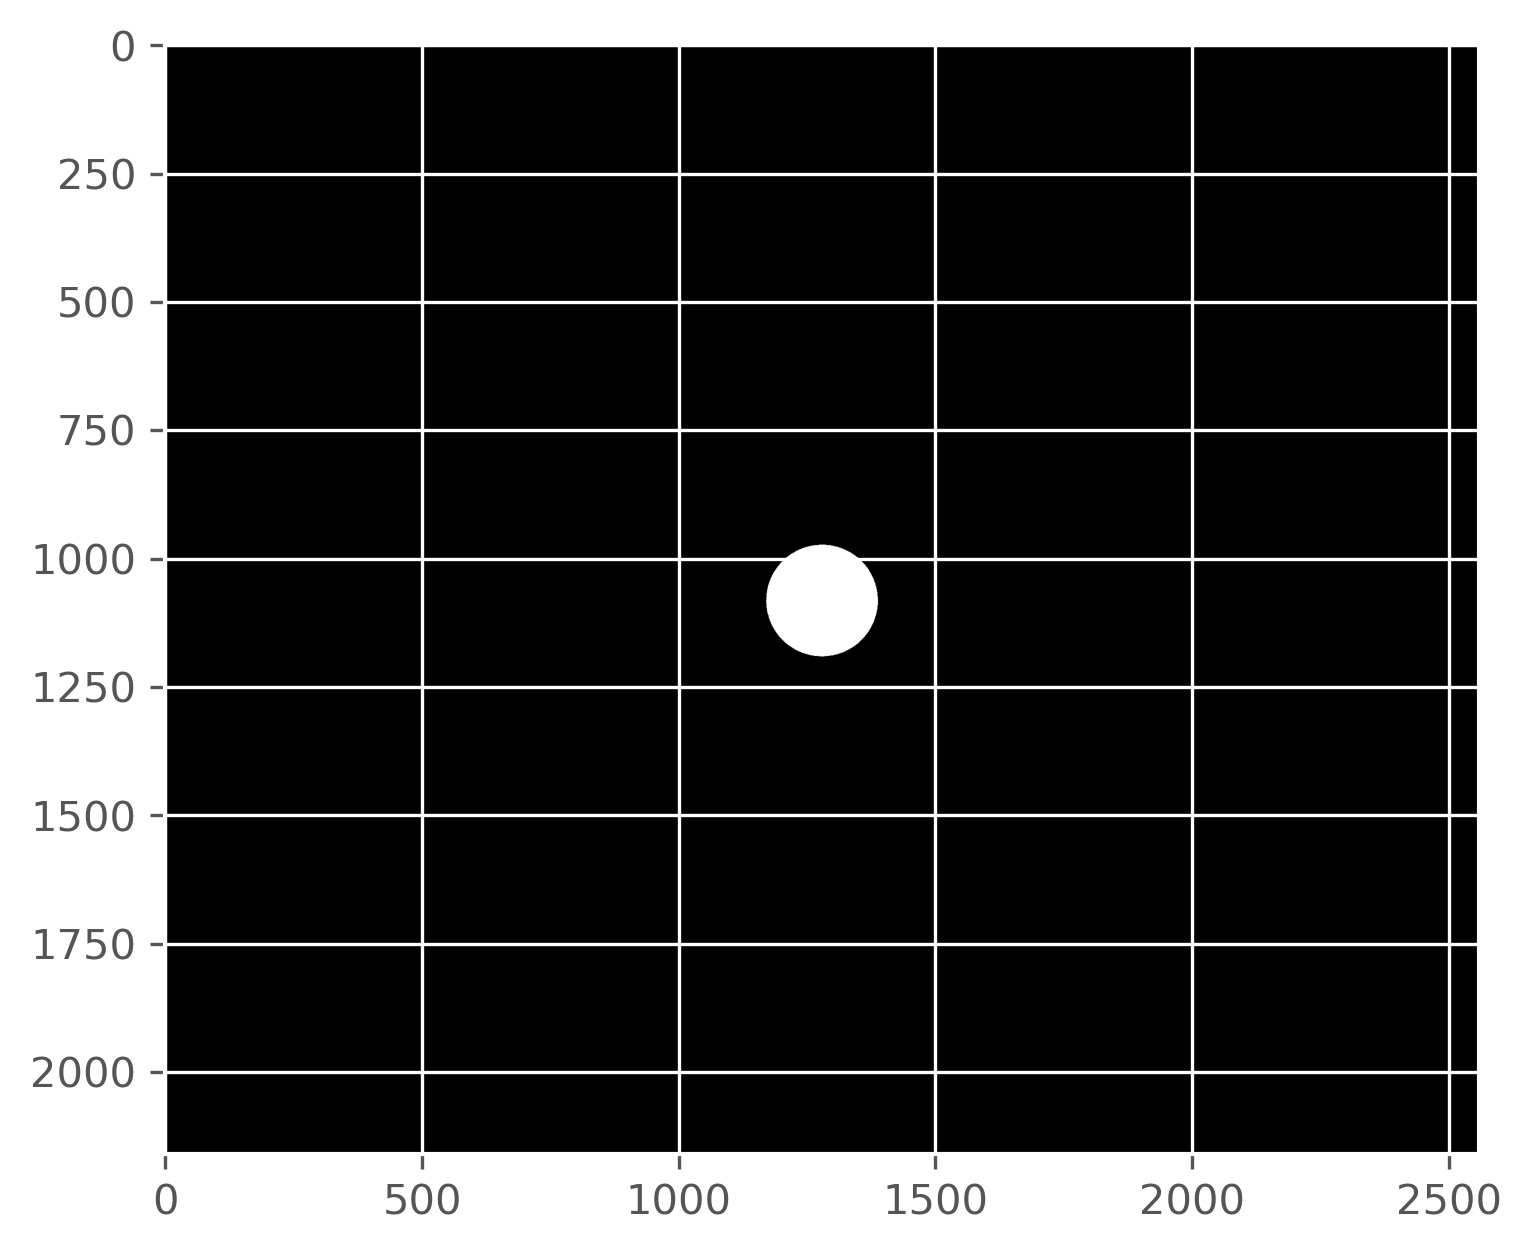

In [81]:
plt.imshow(data_BW[0,:,:])

## Get Center of Mass for each detector position

In [134]:
COM_coors = np.zeros([data.shape[0],3], dtype='float')

In [83]:
from scipy.ndimage import center_of_mass

In [135]:
for slice in range(0, data.shape[0]):
    COM_coors[slice,[1,0]] = center_of_mass(data_BW[slice,:,:])

In [136]:
COM_coors[:,2] = np.arange(55,310,5)

In [67]:
from skimage import filters

In [86]:
data_BW_edge = np.zeros(data.shape, dtype='bool')

In [87]:
for slice in range(0, data.shape[0]):
    data_BW_edge[slice,:,:] = filters.sobel(data_BW[slice, :, :])

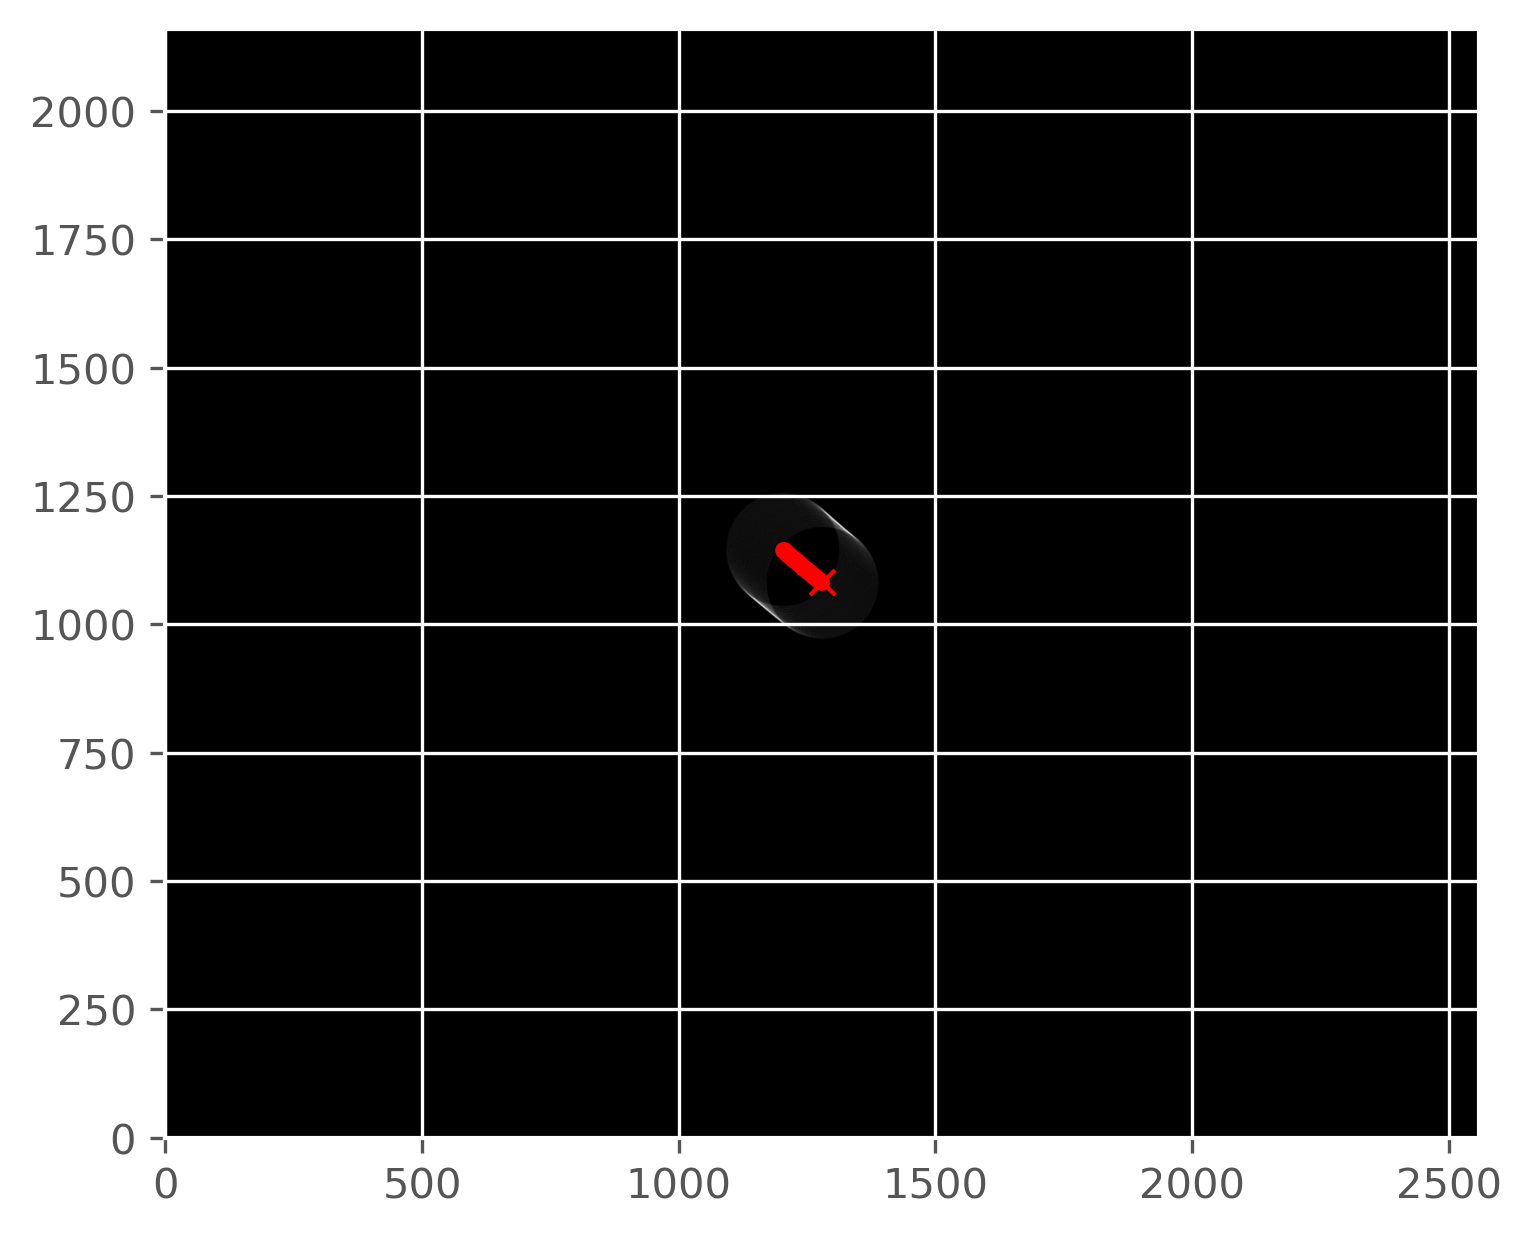

In [137]:
plt.imshow(data_BW_edge.astype('float').sum(axis=0), origin='lower')
plt.plot(COM_coors[1:,0], COM_coors[1:,1], 'r.')
plt.plot(COM_coors[0,0], COM_coors[0,1], 'rx')

### Convert to millimeters

In [138]:
COM_coors_mm = COM_coors.copy()

In [139]:
pixelsize = 0.0031 # [mm]
COM_coors_mm[:,[0,1]] = COM_coors_mm[:,[0,1]]*pixelsize

In [140]:
COM_coors_mm[:,[0,1]] = COM_coors_mm[:,[0,1]]-COM_coors_mm[0,[0,1]]

In [141]:
print('Start:')
print('    X: ', COM_coors_mm[0, 0])
print('    Y: ', COM_coors_mm[0, 1])
print('    Z: ', COM_coors_mm[0, 2])
print('End:')
print('    X: ', COM_coors_mm[-1, 0])
print('    Y: ', COM_coors_mm[-1, 1])
print('    Z: ', COM_coors_mm[-1, 2])

Start:
    X:  0.0
    Y:  0.0
    Z:  55.0
End:
    X:  -0.23494769069549992
    Y:  0.1973468472521911
    Z:  305.0


## 3D fit
See here: https://stackoverflow.com/questions/2298390/fitting-a-line-in-3d

In [142]:
datamean = COM_coors_mm.mean(axis=0)

# Do an SVD on the mean-centered data.
uu, dd, vv = np.linalg.svd(COM_coors_mm - datamean)

# Now vv[0] contains the first principal component, i.e. the direction
# vector of the 'best fit' line in the least squares sense.

In [143]:
print(vv[0])

[-9.41264326e-04  7.93378465e-04  9.99999242e-01]


### Now generate some points along this best fit line, for plotting.

In [144]:
# use -7, 7 since the spread of the data is roughly 14
# and we want it to have mean 0 (like the points we did
# the svd on). Also, it's a straight line, so we only need 2 points.
linepts = vv[0] * np.mgrid[-150:150:2j][:, np.newaxis]

# shift by the mean to get the line in the right place
linepts += datamean

/home/beats/.conda/envs/tomopy-source/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  


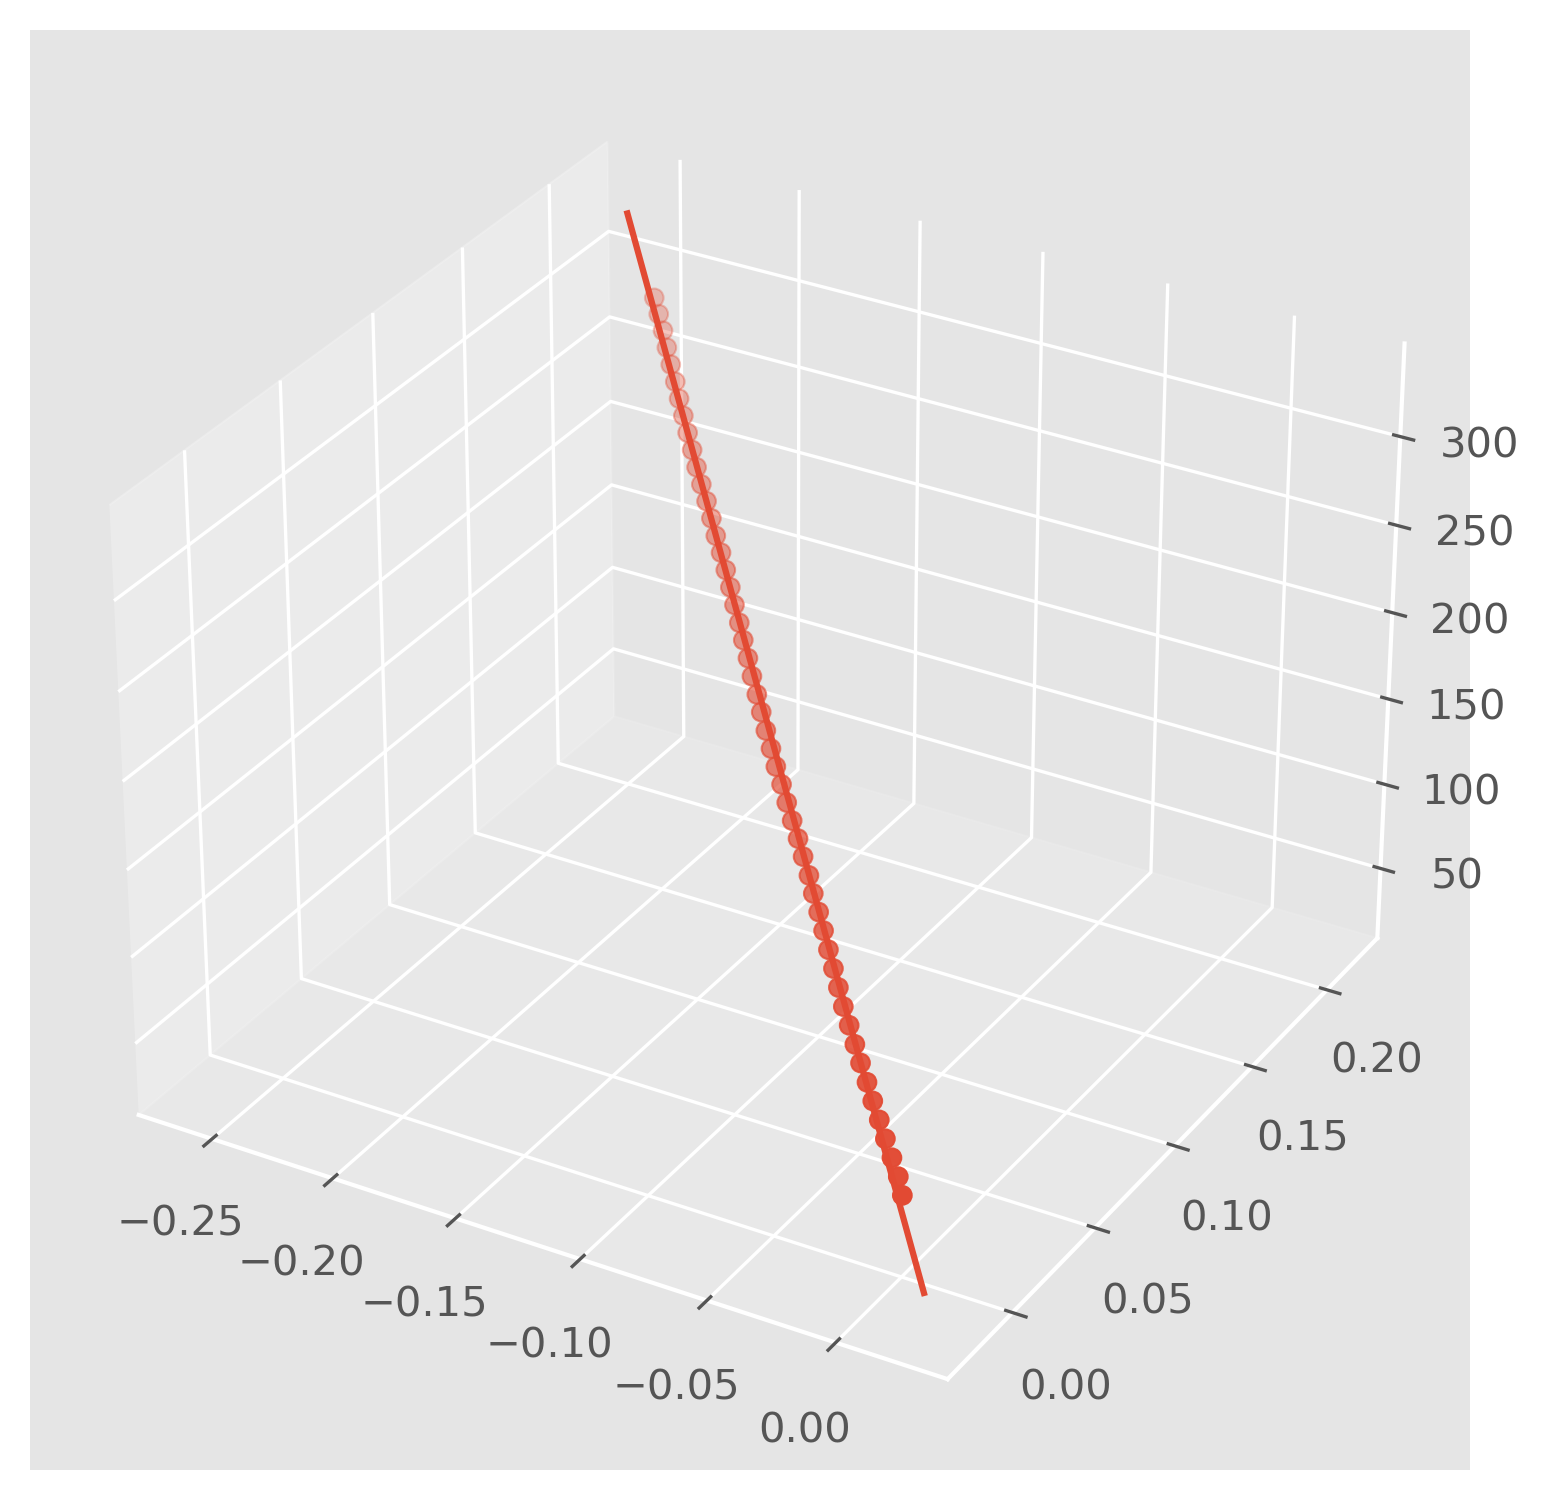

In [145]:
# Verify that everything looks right.

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as m3d

ax = m3d.Axes3D(plt.figure())
ax.scatter3D(*COM_coors_mm.T)
ax.plot3D(*linepts.T)
plt.show()

### Try to straighten the detector line

In [146]:
COM_coors_mm_straight = np.zeros(COM_coors_mm.shape, dtype='float')

In [147]:
COM_coors_mm_straight[:,0] = COM_coors_mm[:,2]*vv[0,0]
COM_coors_mm_straight[:,1] = COM_coors_mm[:,2]*vv[0,1]
COM_coors_mm_straight[:,2] = COM_coors_mm[:,2]

In [148]:
print('Start:')
print('    X: ', COM_coors_mm_straight[0, 0])
print('    Y: ', COM_coors_mm_straight[0, 1])
print('    Z: ', COM_coors_mm_straight[0, 2])
print('End:')
print('    X: ', COM_coors_mm_straight[-1, 0])
print('    Y: ', COM_coors_mm_straight[-1, 1])
print('    Z: ', COM_coors_mm_straight[-1, 2])

Start:
    X:  -0.05176953794973312
    Y:  0.0436358155805227
    Z:  55.0
End:
    X:  -0.2870856195394291
    Y:  0.2419804318556259
    Z:  305.0


In [151]:
COM_coors_mm-(COM_coors_mm_straight-COM_coors_mm_straight[0,:])

array([[ 0.00000000e+00,  0.00000000e+00,  5.50000000e+01],
       [ 5.37086006e-04, -8.40043414e-05,  5.50000000e+01],
       [ 3.14842196e-04, -3.73359952e-04,  5.50000000e+01],
       [-2.14574054e-05, -6.23040781e-04,  5.50000000e+01],
       [-2.03739035e-04, -8.61994959e-04,  5.50000000e+01],
       [-5.44389411e-04, -1.07707988e-03,  5.50000000e+01],
       [-6.23111547e-04, -1.29532842e-03,  5.50000000e+01],
       [-1.10924106e-03, -1.29764582e-03,  5.50000000e+01],
       [-1.16685432e-03, -1.49868539e-03,  5.50000000e+01],
       [-1.39904918e-03, -1.45639994e-03,  5.50000000e+01],
       [-1.59455466e-03, -1.56593073e-03,  5.50000000e+01],
       [-1.64308902e-03, -1.38433807e-03,  5.50000000e+01],
       [-1.69308001e-03, -1.20030327e-03,  5.50000000e+01],
       [-1.74072241e-03, -1.08055813e-03,  5.50000000e+01],
       [-1.82825604e-03, -8.01087938e-04,  5.50000000e+01],
       [-1.80692485e-03, -7.36855785e-04,  5.50000000e+01],
       [-1.94709177e-03, -7.14876997e-04

In [152]:
print(vv[0])

[-9.41264326e-04  7.93378465e-04  9.99999242e-01]


### Example with a set of Det coordinates:

In [154]:
Det_X = 254.
Det_Y = 56.
Det_Z = 55.

In [153]:
delta_Z = 250 # tweek + Det_Z

In [162]:
delta_X = vv[0,0]*delta_Z
delta_Y = vv[0,1]*delta_Z

In [163]:
Det_X_cor = Det_X + delta_X
Det_Y_cor = Det_Y + delta_Y

In [164]:
print('Det_X_cor: ', Det_X_cor)
print('Det_Y_cor: ', Det_Y_cor)

Det_X_cor:  253.7646839184103
Det_Y_cor:  56.1983446162751
